# Importing All the Necessary Libraries

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold

from skimage.io import imread
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose

from tqdm import tqdm
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import keras
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_opening, disk, label

import glob
from torchvision import datasets, models, transforms
from cv2 import imread
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score
import torch.optim as optim
import math 

import torchmetrics 
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**paths**

In [ ]:
train_image_path = '../input/img-sz-256'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'

**configuration class**

In [ ]:
class CFG:
    root = '../input/plant-pathology-2021-fgvc8/train_images'
    INPUT_PATH = '../input/plant-pathology-2021-fgvc8'
    OUTPUT_PATH = './'
    SAMPLE_SUBMISSION_FILE = os.path.join(INPUT_PATH, 'sample_submission.csv')
    SUBMISSION_FILE = os.path.join(OUTPUT_PATH, 'submission.csv')
    classes = [
        'complex', 
        'frog_eye_leaf_spot', 
        'powdery_mildew', 
        'rust', 
        'scab',
        'healthy']

    batch_size = 16
    img_size = 224 # image size
    folds = 5 
    seed = 42 
    min_lr = 1e-7
    t_max = 20
    transform = True # whether to apply pre-augmentations or not
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    treshold_test = np.array([0.3, 0.4, 0.6, 0.6, 0.5, 0.6])
    treshold_list = []
    for i in range(batch_size):
        treshold_list.append([0.3, 0.4, 0.6, 0.6, 0.5, 0.6])
    treshold_list_numpy = np.array(treshold_list)
    treshold_list = torch.tensor(treshold_list)
    treshold_list = treshold_list.to(DEVICE)

**read csv**

In [ ]:
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv', index_col='image')

duplicates = pd.read_csv('../input/duplicates/duplicates.csv')

len(df)

18632

**remove duplicates**

In [ ]:
for i in duplicates['abf0b5a0df028b17.jpg']:
    df.drop(i, inplace = True)

**display images of a given label function**

In [ ]:
def show_image(class_name, examples=2, labels_df=df, train_images_path=train_image_path):
    image_list = labels_df[labels_df['labels'] == class_name].index[:examples]
    plt.figure(figsize=(20,10))
    for i, img in enumerate(image_list):
        full_path = os.path.join(train_images_path, img)
        img = Image.open(full_path)
        plt.subplot(1 ,examples, i%examples +1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(class_name)

# Understanding the different types of classes(Diseases)

# 1. Healthy

 images of a helthy trees.

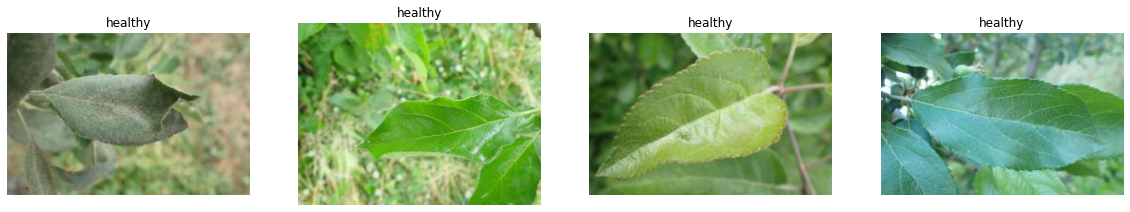

In [ ]:
show_image(class_name='healthy', examples=4)

# 2. Scab
Scab is a disease of apples and ornamental crabapples, apple scab (Venturia inaequalis) attacks both leaves and fruit. The fungal disease forms pale yellow or olive-green spots on the upper surface of leaves. Dark, velvety spots may appear on the lower surface. Severely infected leaves become twisted and puckered and may drop early in the summer.

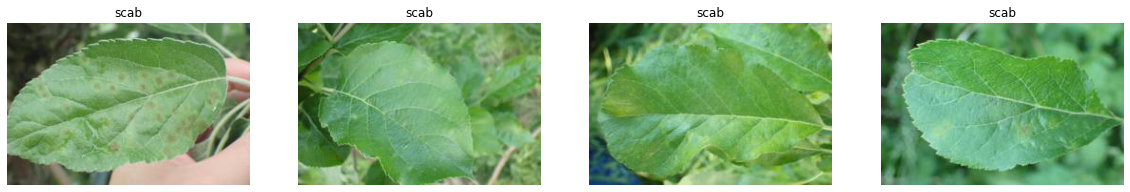

In [ ]:
show_image(class_name='scab', examples=4)

# 3. Frog eye leaf spot
small purple spots form on the leaves. These spots gradually enlarge and eventually develop into lesions with a light tan interior, surrounded by a dark purple perimeter. Heavy infections of frog-eye leaf spot can cause leaves to turn yellow and drop.

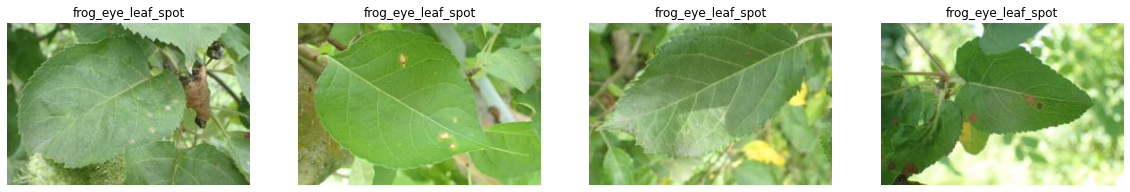

In [ ]:
show_image(class_name='frog_eye_leaf_spot', examples=4)

# 4. Complex
According to data description:- Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.

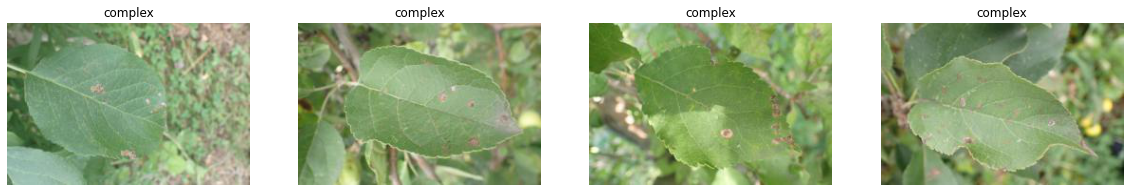

In [ ]:
show_image(class_name='complex', examples=4)

# 5. rust
Circular, yellow spots (lesions) appear on the upper surfaces of the leaves shortly after bloom. In late summer, brownish clusters of threads or cylindrical tubes (aecia) appear beneath the yellow leaf spots or on fruits and twigs.

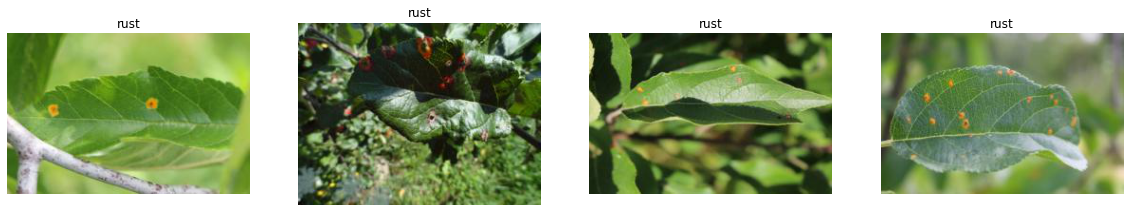

In [ ]:
show_image(class_name='rust', examples=4)

# 6. Powdery Mildew
Powdery mildew is a fungal disease that affects a wide range of plants.
Powdery mildew is one of the easier plant diseases to identify, as its symptoms are quite distinctive. Infected plants display white powdery spots on the leaves and stems.

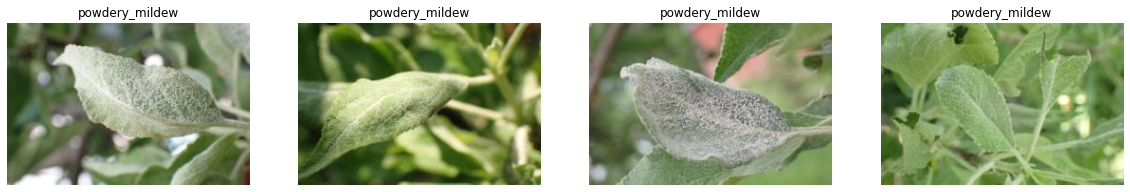

In [ ]:
show_image(class_name='powdery_mildew', examples=4)

# 7. Scab + Frog eye leaf spot
combination of Scab and Frog eye leaf spot

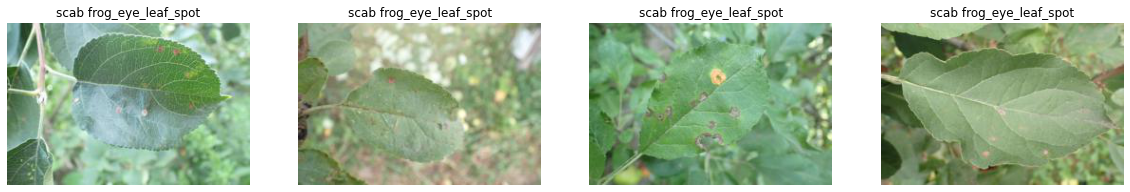

In [ ]:
show_image(class_name='scab frog_eye_leaf_spot', examples=4)

# 8. Scab + Frog eye leaf spot + Complex
similar to the previous class, but might have some additional diseases as well.

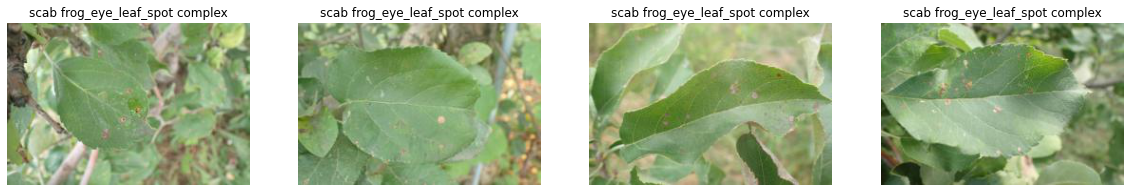

In [ ]:
show_image(class_name='scab frog_eye_leaf_spot complex', examples=4)

# 9. Frog eye leaf spot + Complex
combination of Frog eye leaf spot and some unkown disease.

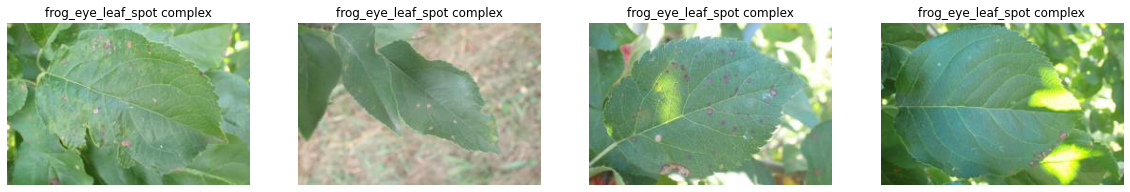

In [ ]:
show_image(class_name='frog_eye_leaf_spot complex', examples=4)

# 10. Rust + Frog eye leaf spot
combination of Rust and Frog eye leaf spot.

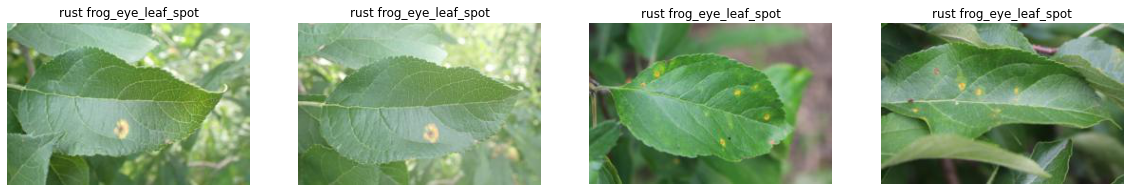

In [ ]:
show_image(class_name='rust frog_eye_leaf_spot', examples=4)

# 11. Powdery Mildew + complex
combination of powdery mildew and some unknown disease

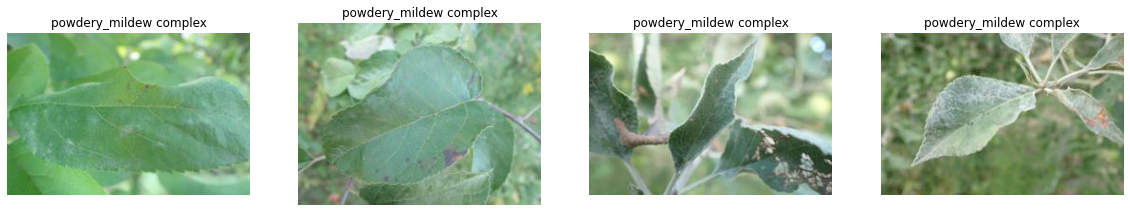

In [ ]:
show_image(class_name='powdery_mildew complex', examples=4)

# 12. Rust + Complex
combination of Rust and some unknown disease**

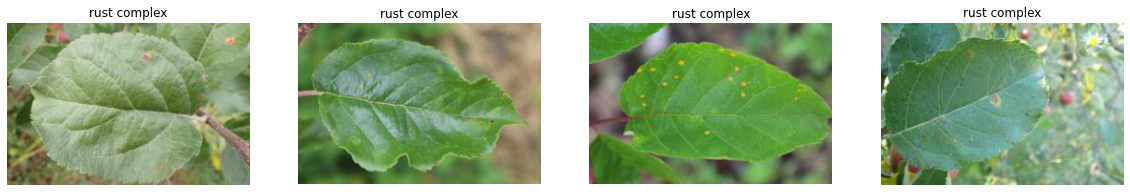

In [ ]:
show_image(class_name='rust complex', examples=4)

# display augmentations

In [ ]:
def aug_example():
    return A.Compose([
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.Blur(p=0.4),
            A.GaussianBlur(p=0.4),
            A.MotionBlur(p=0.4),
        ], p=0.4),
        A.OneOf([
            A.GaussNoise(p=0.4),
            A.ISONoise(p=0.4),
            A.GridDropout(ratio=0.5, p=0.2),
            A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
        ], p=0.2)
    ])

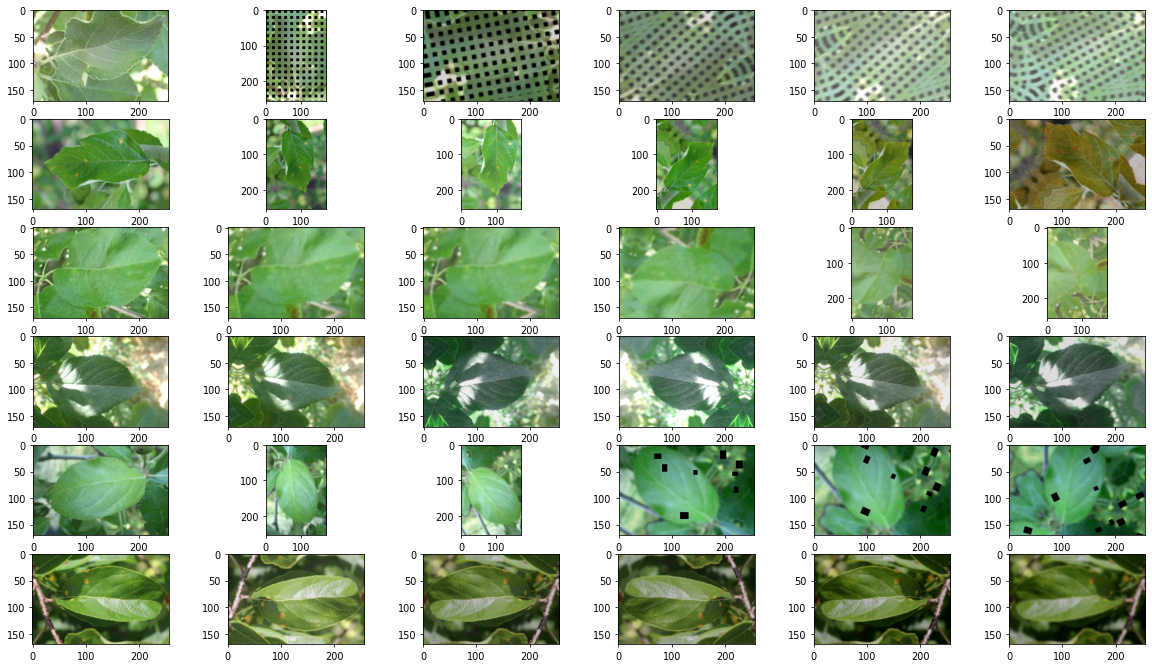

In [ ]:
tmp_df = df.sample(6)
image_ids = tmp_df.index
indx = 0

plt.figure(figsize=(21, 12), dpi=70)

for i in image_ids:
    
    image_id = i

    image_path = train_image_path + '/' + image_id
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(6, 6, indx + 1)
    plt.imshow(image)
    indx += 1
    for j in range(5):
        image = aug_example()(image=image)["image"]
        plt.subplot(6, 6, indx + 1)
        plt.imshow(image)
        indx += 1

plt.show()

# labels statistics and counts

In [ ]:
df['labels'].value_counts()

scab                               4819
healthy                            4624
frog_eye_leaf_spot                 3180
rust                               1825
complex                            1592
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             119
rust complex                         96
powdery_mildew complex               87
Name: labels, dtype: int64

**Frequency of Each Class**

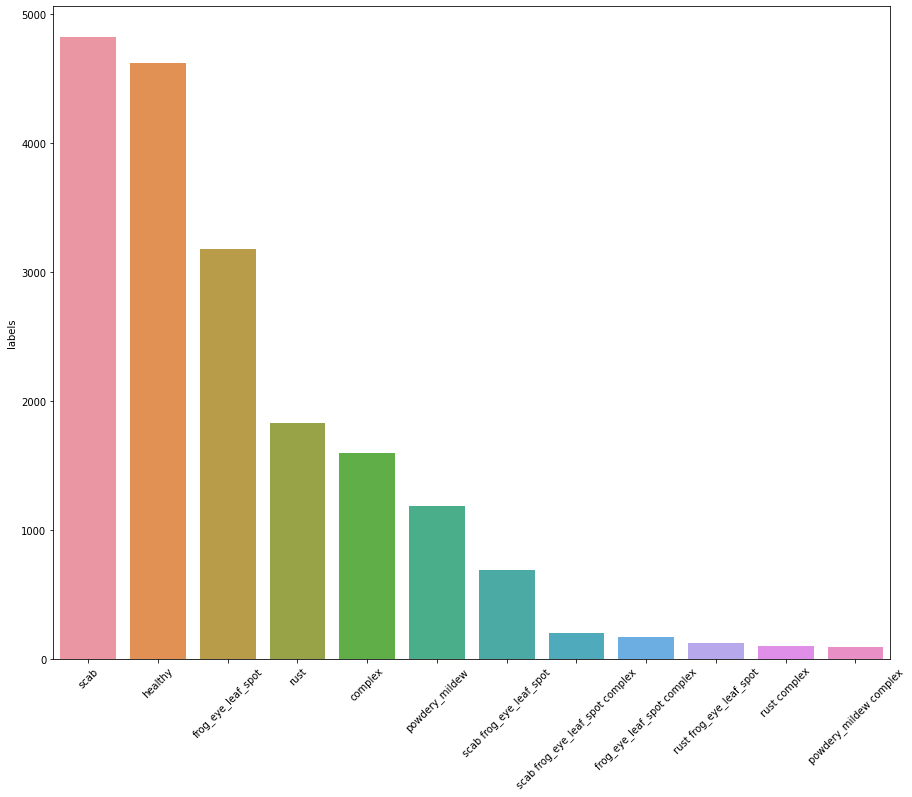

In [ ]:
plt.figure(figsize=(15,12))
labels = sns.barplot(df.labels.value_counts().index,df.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [ ]:
source = df['labels'].value_counts()
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

**split the data to train and validation**

In [ ]:
sfk = StratifiedKFold(CFG.folds)
for train_idx, valid_idx in sfk.split(df.index, df['labels']):
    df_train = df.iloc[train_idx]
    df_valid = df.iloc[valid_idx]
    break

In [ ]:
print(f"train size: {len(df_train)}")
print(f"valid size: {len(df_valid)}")

train size: 14861
valid size: 3716


In [ ]:
df

labels
image                                                
800113bb65efe69e.jpg                          healthy
8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
80070f7fb5e2ccaa.jpg                             scab
80077517781fb94f.jpg                             scab
800cbf0ff87721f8.jpg                          complex
...                                               ...
fffb900a92289a33.jpg                          healthy
fffc488fa4c0e80c.jpg                             scab
fffc94e092a59086.jpg                             rust
fffe105cf6808292.jpg          scab frog_eye_leaf_spot
fffe472a0001bd25.jpg                          healthy

[18577 rows x 1 columns]

# label formatting
**we changed the lable format to one hot encoding for model training**

In [ ]:
original_labels = df_train['labels'].values.copy()

df_train['labels'] = [x.split(' ') for x in df_train['labels']]
labels = MultiLabelBinarizer(classes=CFG.classes).fit_transform(df_train['labels'].values)

df_train = pd.DataFrame(columns=CFG.classes, data=labels, index=df_train.index)

original_labels = df_valid['labels'].values.copy()

df_valid['labels'] = [x.split(' ') for x in df_valid['labels']]
labels = MultiLabelBinarizer(classes=CFG.classes).fit_transform(df_valid['labels'].values)

df_valid = pd.DataFrame(columns=CFG.classes, data=labels, index=df_valid.index)


In [ ]:
df_train

complex  frog_eye_leaf_spot  powdery_mildew  rust  scab  \
image                                                                           
959b7465c95233c3.jpg        0                   0               1     0     0   
95b1e94a23f5a958.jpg        0                   0               1     0     0   
95b34b89d005b4df.jpg        0                   0               1     0     0   
95b44bc3a87077ca.jpg        0                   0               1     0     0   
95cb3b9998371299.jpg        0                   0               1     0     0   
...                       ...                 ...             ...   ...   ...   
fffb900a92289a33.jpg        0                   0               0     0     0   
fffc488fa4c0e80c.jpg        0                   0               0     0     1   
fffc94e092a59086.jpg        0                   0               0     1     0   
fffe105cf6808292.jpg        0                   1               0     0     1   
fffe472a0001bd25.jpg        0                   0               0     0     0   

                      healthy  
image                          
959b7465c95233c3.jpg        0  
95b1e94a23f5a958.jpg        0  
95b34b89d005b4df.jpg        0  
95b44bc3a87077ca.jpg        0  
95cb3b9998371299.jpg        0  
...                       ...  
fffb900a92289a33.jpg        1  
fffc488fa4c0e80c.jpg        0  
fffc94e092a59086.jpg        0  
fffe105cf6808292.jpg        0  
fffe472a0001bd25.jpg        1  

[14861 rows x 6 columns]

**augmentation function**

In [ ]:
def get_transform(phase: str):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(height=CFG.img_size, width=CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.OneOf([
            A.RandomBrightnessContrast(p=0.5),A.RandomGamma(p=0.5)], p=0.5),
            A.OneOf([
            A.Blur(p=0.4),
            A.GaussianBlur(p=0.4),
            A.MotionBlur(p=0.4)], p=0.4),
            A.OneOf([
            A.GaussNoise(p=0.4),
            A.ISONoise(p=0.4),
            A.GridDropout(ratio=0.5, p=0.2),
            A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)], p=0.2),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=CFG.img_size, width=CFG.img_size),
            A.Normalize(),
            ToTensorV2(),
        ])

**augmentation -** 

* RandomResizedCrop - crop a random part of the input and rescale it to some size. croping the image without damagging too much to the image details.
* HorizontalFlip - Flip the input horizontally around the y-axis. Fliping the image wont cause damage to the image details.
* ShiftScaleRotate - Randomly apply affine transforms: translate, scale and rotate the input.
* RandomBrightnessContrast - Randomly change brightness and contrast of the input image. changing brightness and contrast to the image wont cause damage to the image details.
* Blur - Blur the input image using a random-sized kernel. Blurring the image won't cause damage to the image details.
* gaussianblur - Blur the input image using a Gaussian filter with a random kernel size.
* motionblur - Apply motion blur to the input image using a random-sized kernel.
* gaussNoise - Apply gaussian noise to the input image. Adding Noise to the image wont cause damage to the image details.
* ISONoise - Apply camera sensor noise.
* GridDropout - GridDropout, drops out rectangular regions of an image and the corresponding mask in a grid fashion. Dropout of small     recrangular regions of the image.
* CoarseDropout - CoarseDropout of the rectangular regions in the image.


**dataset class**

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None, kind='train'):
        self.image_id = df.index
        self.labels = df.iloc[:, :].values
        self.transform = transform
        self.kind = kind

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_id[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.kind == 'train':
            image_path = train_image_path + '/' + image_id
        elif self.kind == 'test':
            image_path = test_image_path + '/' + image_id
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

**create train and valid loaders**

In [ ]:
train_dataset = PlantDataset(df_train, get_transform('train'))
valid_dataset = PlantDataset(df_valid, get_transform('valid'))

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

# assistance functions

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**calculate f1 scores metrics**

In [ ]:
def calculate_metrics(pred, target):

    return {

            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),

            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),

            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),

            }


**train function we created**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEBUG = False 
def train(train_loader, model, optimizer, epoch, criterion, model_name):
    m = nn.Sigmoid()
    accuracy = AverageMeter()
    losses = AverageMeter()
    f1_micro = AverageMeter()
    f1_macro = AverageMeter()
    f1_samples = AverageMeter()
    model.train()

    for i, (img, target) in tqdm(enumerate(train_loader)):
        img = img.float()    

        img = img.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(img)
        if DEBUG:
            print('output',output.detach().cpu().numpy(),
                    'shape', output.detach().cpu().numpy().shape )

            print('target',target.detach().cpu().numpy(),
                    'shape', target.detach().cpu().numpy().shape )

        
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
    
        pred = m(output)
        pred_max = torch.argmax(pred, dim = 1)
        
        if pred.shape[0] != CFG.batch_size:
            treshold_list = CFG.treshold_list[ :pred.shape[0], : ]
            pred = (pred > treshold_list).int()
        else:
            pred = (pred > CFG.treshold_list).int()
        
        pred_sum = torch.sum(pred, 1)

        for i,j,k in zip(pred, pred_sum, pred_max):
            if j == 0:
                i[k] = 1
        
        acc = torchmetrics.functional.accuracy(pred, target.int())
        
        losses.update(loss.item(), img.size(0))
        accuracy.update(acc, img.size(0))
        
        result = calculate_metrics(to_numpy(pred.float()), to_numpy(target))
        
        f1_micro.update(result['micro/f1'], img.size(0))
        f1_macro.update(result['macro/f1'], img.size(0))
        f1_samples.update(result['samples/f1'], img.size(0))
        
        torch.cuda.empty_cache()
    
    print(' average training loss', losses.avg,  epoch)
    print(' average training accuracy', accuracy.avg*100,  epoch)
    print(' average training micro f1 score', f1_micro.avg,  epoch)
    print(' average training macro f1 score', f1_macro.avg,  epoch)
    print(' average training samples f1 score', f1_samples.avg,  epoch)
    
    return losses.avg, accuracy.avg*100, f1_micro.avg, f1_macro.avg, f1_samples.avg

**validate function we created**

In [ ]:
best_acc = 0
def validate(dataloader, model, criterion, optimizer, epoch, model_name):
    m = nn.Sigmoid()
    acc = AverageMeter()
    losses = AverageMeter()
    f1_micro = AverageMeter()
    f1_macro = AverageMeter()
    f1_samples = AverageMeter()
    model.eval()
    loss_accumlated = 0
    for i, (x_batch, y_batch) in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch.float()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad() 
        
        output = model(x_batch) 
        
        
        loss = criterion(output, y_batch)
        losses.update(loss.item(), x_batch.size(0))
        loss_accumlated += loss.item()
                
        pred = m(output)
        
        pred_max = torch.argmax(pred, dim = 1)
        
        if pred.shape[0] != CFG.batch_size:
            treshold_list = CFG.treshold_list[ :pred.shape[0], : ]
            pred = (pred > treshold_list).int()
        else:
            pred = (pred > CFG.treshold_list).int()
        
        pred_sum = torch.sum(pred, 1)

        for i,j,k in zip(pred, pred_sum, pred_max):
            if j == 0:
                i[k] = 1
        
        accuracy = torchmetrics.functional.accuracy(pred,  y_batch.int())

        acc.update(accuracy, x_batch.size(0))
        
        result = calculate_metrics(to_numpy(pred.float()), to_numpy(y_batch))
        
        f1_micro.update(result['micro/f1'], x_batch.size(0))
        f1_macro.update(result['macro/f1'], x_batch.size(0))
        f1_samples.update(result['samples/f1'], x_batch.size(0))
        
        torch.cuda.empty_cache()

    print(' average valid loss', losses.avg,  epoch)
    print(' average valid accuracy', acc.avg*100,  epoch)
    print(' average valid micro f1 score', f1_micro.avg,  epoch)
    print(' average valid macro f1 score', f1_macro.avg,  epoch)
    print(' average valid samples f1 score', f1_samples.avg,  epoch)

    return losses.avg, acc.avg*100, f1_micro.avg, f1_macro.avg, f1_samples.avg

**a function for training the model**

In [ ]:
def train_model(loader_train, loader_val, model, optimizer, criterion, model_name, num_epochs, scheduler=None):
    EPOCHS = num_epochs
    losses_train = []
    acc_train = []
    losses_val = []
    acc_val = []
    f1_micro_train = []
    f1_macro_train = []
    f1_samples_train = []
    f1_micro_valid = []
    f1_macro_valid = []
    f1_samples_valid = []
    for e in range(EPOCHS):
        result_train = train(loader_train, model, opt3, e, criterion, model_name=model_name)
        result_val = validate(loader_val, model, criterion, opt3, e, model_name=model_name)
        if scheduler:
            scheduler.step()
        print('epoch - ' + str(e) + ' end')
        print('lr - ' + str(optimizer.param_groups[0]['lr']))
#         if e == 6:
#             optimizer.param_groups[0]['lr'] = 0.000006
#         if e == 12:
#             optimizer.param_groups[0]['lr'] = 0.000001
        losses_train.append(result_train[0])
        acc_train.append(result_train[1])
        losses_val.append(result_val[0])
        acc_val.append(result_val[1])
        f1_micro_train.append(result_train[2])
        f1_macro_train.append(result_train[3])
        f1_samples_train.append(result_train[4])
        f1_micro_valid.append(result_val[2])
        f1_macro_valid.append(result_val[3])
        f1_samples_valid.append(result_val[4])
    return   losses_train, acc_train, f1_micro_train, f1_macro_train, f1_samples_train, losses_val, acc_val, f1_micro_valid, f1_macro_valid, f1_samples_valid

**convert tensor to numpy**

In [ ]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

**softmax function for numpy**

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) # only difference

**sigmoid function for numpy**

In [ ]:
def Sigmoid(x):
    return 1/(1 + np.exp(-x))

**plot confusion matrix function**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(
    y_test, 
    y_pred_proba, 
    label_names=CFG.classes
)-> None:
    """
    """
    y_pred = y_pred_proba
    c_matrices = multilabel_confusion_matrix(y_test, y_pred)
    
    cmap = plt.get_cmap('Blues')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    for cm, label, ax in zip(c_matrices, label_names, axes.flatten()):
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap);

        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title(f'{label}');

    plt.tight_layout()    
    plt.show()

**model prediction output**

In [ ]:
def predict(model, loader):
    y_true = np.empty(shape=(0, 6), dtype=np.int)
    y_pred_proba = np.empty(shape=(0, 6), dtype=np.int)
    model.eval()
    stream = tqdm(loader)
    pred_avg = [0, 0, 0, 0, 0, 0]
    pred_counts = [0, 0, 0, 0, 0, 0]
    pred_avg_0 = [0, 0, 0, 0, 0, 0]
    pred_counts_0 = [0, 0, 0, 0, 0, 0]
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.to(CFG.DEVICE)
        y = to_numpy(y.to(CFG.DEVICE))
        pred = to_numpy(model(X))
        
#         pred = Sigmoid(pred)
#         pred = softmax(pred)
        
        for i,j in zip(pred, y):
             for k in range(6):
                    if j[k] == 1:
                        pred_avg[k] += i[k]
                        pred_counts[k] += 1
                    else:
                        pred_avg_0[k] += i[k]
                        pred_counts_0[k] += 1
        
        pred_max = np.argmax(pred, 1)
        
        if pred.shape[0] != CFG.batch_size:
            treshold_list = CFG.treshold_list_numpy[ :pred.shape[0], : ]
            pred = (pred > treshold_list).astype(int)
        else:
            pred = (pred > CFG.treshold_list_numpy).astype(int)
        pred_sum = np.sum(pred, 1)

        for i,j,k in zip(pred, pred_sum, pred_max):
            if j == 0:
                i[k] = 1
            if i[5] == 1 and j>1:
                if k == 5:
                    i = np.array([0,0,0,0,0,1])
                else:
                    i[5] = 0
        
        y_true = np.vstack((y_true, y))
        y_pred_proba = np.vstack((y_pred_proba, pred))
    avg = [i/j for i, j in zip (pred_avg,pred_counts)]
    avg_0 = [i/j for i, j in zip (pred_avg_0,pred_counts_0)]
    print('average output values for true label' + str(avg))
    print('average output values for false label' + str(avg_0))
    return y_true, y_pred_proba

**calculate the accuracy of samples prediction**

In [ ]:
def acc(y_test, y_pred):
    true = 0
    false = 0
    for i, j in zip (y_test, y_pred):
        pred = (i == j).astype(int)
        pred_sum = np.sum(pred)
        if pred_sum != 6:
            false += 1
        else:
            true += 1
    return true/(true+false)

**ensemble class we created**

In [ ]:
import torch.nn.functional as F
class MyEnsemble(nn.Module):
    def __init__(self, models):
        super(MyEnsemble, self).__init__()
        self.models = []
        for model in models:
            self.models.append(model)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        allX = []
        for model in self.models:
            allX.append(self.Sigmoid(model(x.clone())))
        x = sum(allX)/len(allX)
        return x

**load the pre-trained pytorch resnet34 model for transfer learning** 

In [ ]:
model_resNet34 = torch.load('../input/model-resnet34/model_resnet34')

In [ ]:
model_resNet34 = model_resNet34.cuda()
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(model_resNet34.parameters(), lr = 0.00001, weight_decay=0.01 )
opt3 = torch.optim.AdamW(model_resNet34.parameters(), lr=0.00001, weight_decay=0.01)
opt1 = optim.SGD(model_resNet34.parameters(), lr = 0.0001, momentum=0.9)

In [ ]:
scheduler1 = torch.optim.lr_scheduler.StepLR(opt3, 4, gamma=0.4, last_epoch=-1, verbose=False)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt3, mode='min', factor=0.1, patience=20, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
scheduler3 = torch.optim.lr_scheduler.CosineAnnealingLR(opt3, T_max=CFG.t_max, eta_min=CFG.min_lr)

**train model**

In [ ]:
logs = train_model(train_loader, valid_loader, model_resNet34, opt3, criterion, num_epochs = 15, model_name='resnet34_pytorch', scheduler = None)

928it [02:19,  6.66it/s]

 average training loss 0.3834727120682083 0
 average training accuracy tensor(80.9424, device='cuda:0') 0
 average training micro f1 score 0.5529737585853806 0
 average training macro f1 score 0.4594876012522645 0
 average training samples f1 score 0.5542882158251231 0



233it [00:20, 11.23it/s]

 average valid loss 0.20800306401801957 0
 average valid accuracy tensor(91.8775, device='cuda:0') 0
 average valid micro f1 score 0.7787539901058014 0
 average valid macro f1 score 0.6330032643457646 0
 average valid samples f1 score 0.7936670254754215 0
epoch - 0 end
lr - 1e-05



928it [02:18,  6.72it/s]

 average training loss 0.2460765909435677 1
 average training accuracy tensor(89.3835, device='cuda:0') 1
 average training micro f1 score 0.7086198832097546 1
 average training macro f1 score 0.6103507061117553 1
 average training samples f1 score 0.7198635057471263 1



233it [00:14, 16.21it/s]


 average valid loss 0.17504306800013852 1
 average valid accuracy tensor(93.1557, device='cuda:0') 1
 average valid micro f1 score 0.8111705621556606 1
 average valid macro f1 score 0.6668165159107542 1
 average valid samples f1 score 0.8258790814495865 1
epoch - 1 end
lr - 1e-05


928it [02:19,  6.63it/s]

 average training loss 0.22528722424638167 2
 average training accuracy tensor(90.3892, device='cuda:0') 2
 average training micro f1 score 0.7350871581540733 2
 average training macro f1 score 0.6327555991626417 2
 average training samples f1 score 0.7470994971264365 2



233it [00:15, 15.18it/s]

 average valid loss 0.15671312273254437 2
 average valid accuracy tensor(93.9541, device='cuda:0') 2
 average valid micro f1 score 0.8333192429945093 2
 average valid macro f1 score 0.6923356276087498 2
 average valid samples f1 score 0.8487351991388591 2
epoch - 2 end
lr - 1e-05



928it [02:20,  6.61it/s]

 average training loss 0.20969994041008938 3
 average training accuracy tensor(90.9506, device='cuda:0') 3
 average training micro f1 score 0.7511527794927808 3
 average training macro f1 score 0.65619987812171 3
 average training samples f1 score 0.7643341415229872 3



233it [00:15, 15.48it/s]

 average valid loss 0.14255046638368404 3
 average valid accuracy tensor(94.3981, device='cuda:0') 3
 average valid micro f1 score 0.8481061091536983 3
 average valid macro f1 score 0.7042756166062297 3
 average valid samples f1 score 0.8641908862576245 3
epoch - 3 end
lr - 1e-05



928it [02:20,  6.59it/s]

 average training loss 0.2033385222312063 4
 average training accuracy tensor(91.3255, device='cuda:0') 4
 average training micro f1 score 0.7621726842783106 4
 average training macro f1 score 0.6627967540117163 4
 average training samples f1 score 0.7756353268678153 4



233it [00:15, 15.44it/s]

 average valid loss 0.14571425391699963 4
 average valid accuracy tensor(93.9272, device='cuda:0') 4
 average valid micro f1 score 0.8346202745716845 4
 average valid macro f1 score 0.6961359260712265 4
 average valid samples f1 score 0.8507355579476138 4
epoch - 4 end
lr - 1e-05



928it [02:21,  6.58it/s]

 average training loss 0.19824939825700533 5
 average training accuracy tensor(91.5275, device='cuda:0') 5
 average training micro f1 score 0.7667594405567596 5
 average training macro f1 score 0.6633594666350947 5
 average training samples f1 score 0.7799703663793096 5



233it [00:15, 14.72it/s]

 average valid loss 0.1325941366355052 5
 average valid accuracy tensor(94.9183, device='cuda:0') 5
 average valid micro f1 score 0.860746499376571 5
 average valid macro f1 score 0.7174380216020774 5
 average valid samples f1 score 0.8778525296017221 5
epoch - 5 end
lr - 1e-05



928it [02:20,  6.60it/s]

 average training loss 0.19392860324346814 6
 average training accuracy tensor(91.6856, device='cuda:0') 6
 average training micro f1 score 0.7719036920348734 6
 average training macro f1 score 0.6733324481914102 6
 average training samples f1 score 0.7851315553160911 6



233it [00:17, 13.00it/s]

 average valid loss 0.1309991329507371 6
 average valid accuracy tensor(94.5013, device='cuda:0') 6
 average valid micro f1 score 0.850768461480862 6
 average valid macro f1 score 0.7121201877716812 6
 average valid samples f1 score 0.8680660208109074 6
epoch - 6 end
lr - 1e-05



928it [02:23,  6.46it/s]

 average training loss 0.18457768547974912 7
 average training accuracy tensor(92.1864, device='cuda:0') 7
 average training micro f1 score 0.7858237593509814 7
 average training macro f1 score 0.6925483193105721 7
 average training samples f1 score 0.8002379669540216 7



233it [00:15, 15.04it/s]

 average valid loss 0.11891627174564531 7
 average valid accuracy tensor(95.3220, device='cuda:0') 7
 average valid micro f1 score 0.8741303948970771 7
 average valid macro f1 score 0.7312079802194404 7
 average valid samples f1 score 0.8907875852170796 7
epoch - 7 end
lr - 1e-05



928it [02:23,  6.47it/s]

 average training loss 0.1814914886028795 8
 average training accuracy tensor(92.3378, device='cuda:0') 8
 average training micro f1 score 0.7899522134955439 8
 average training macro f1 score 0.690752705756885 8
 average training samples f1 score 0.8039331896551721 8



233it [00:17, 13.51it/s]

 average valid loss 0.12239341388894616 8
 average valid accuracy tensor(95.0170, device='cuda:0') 8
 average valid micro f1 score 0.8643417896865055 8
 average valid macro f1 score 0.7201539186321643 8
 average valid samples f1 score 0.8799336203803372 8
epoch - 8 end
lr - 1e-05



928it [02:20,  6.61it/s]

 average training loss 0.17701479754057423 9
 average training accuracy tensor(92.5265, device='cuda:0') 9
 average training micro f1 score 0.7952558732864495 9
 average training macro f1 score 0.6978318958962032 9
 average training samples f1 score 0.8086408943965497 9



233it [00:13, 17.22it/s]

 average valid loss 0.12220320120389674 9
 average valid accuracy tensor(95.1291, device='cuda:0') 9
 average valid micro f1 score 0.8679618336326415 9
 average valid macro f1 score 0.7251624006023473 9
 average valid samples f1 score 0.8842841765339075 9
epoch - 9 end
lr - 1e-05



928it [02:21,  6.57it/s]

 average training loss 0.17369085594867195 10
 average training accuracy tensor(92.7556, device='cuda:0') 10
 average training micro f1 score 0.8020169351775795 10
 average training macro f1 score 0.7020169122745833 10
 average training samples f1 score 0.8160874640804574 10



233it [00:13, 16.81it/s]

 average valid loss 0.12156831736168128 10
 average valid accuracy tensor(95.0708, device='cuda:0') 10
 average valid micro f1 score 0.8654879563349991 10
 average valid macro f1 score 0.7287339342684377 10
 average valid samples f1 score 0.8810010764262646 10
epoch - 10 end
lr - 1e-05



928it [02:20,  6.58it/s]

 average training loss 0.17377477437498626 11
 average training accuracy tensor(92.6196, device='cuda:0') 11
 average training micro f1 score 0.7977346448942986 11
 average training macro f1 score 0.6994692067532139 11
 average training samples f1 score 0.8120824353448256 11



233it [00:17, 13.43it/s]

 average valid loss 0.11464770074103697 11
 average valid accuracy tensor(95.3310, device='cuda:0') 11
 average valid micro f1 score 0.875274317245534 11
 average valid macro f1 score 0.7361153042225228 11
 average valid samples f1 score 0.8931019016864009 11
epoch - 11 end
lr - 1e-05



928it [02:23,  6.45it/s]

 average training loss 0.16830647212115984 12
 average training accuracy tensor(92.9194, device='cuda:0') 12
 average training micro f1 score 0.8063300717987849 12
 average training macro f1 score 0.7079549310171523 12
 average training samples f1 score 0.8212890624999997 12



233it [00:15, 14.75it/s]

 average valid loss 0.11056704558151402 12
 average valid accuracy tensor(95.5687, device='cuda:0') 12
 average valid micro f1 score 0.8811080714390178 12
 average valid macro f1 score 0.7343000582941054 12
 average valid samples f1 score 0.8980624327233584 12
epoch - 12 end
lr - 1e-05



928it [02:21,  6.55it/s]

 average training loss 0.16634672190512306 13
 average training accuracy tensor(93.0226, device='cuda:0') 13
 average training micro f1 score 0.809118602212206 13
 average training macro f1 score 0.710855525011688 13
 average training samples f1 score 0.8245487607758613 13



233it [00:15, 15.43it/s]

 average valid loss 0.10815518205851092 13
 average valid accuracy tensor(95.6359, device='cuda:0') 13
 average valid micro f1 score 0.8834381444266758 13
 average valid macro f1 score 0.7372996444710213 13
 average valid samples f1 score 0.9004395407247935 13
epoch - 13 end
lr - 1e-05



928it [02:21,  6.54it/s]

 average training loss 0.1631336205976148 14
 average training accuracy tensor(93.1102, device='cuda:0') 14
 average training micro f1 score 0.8116801043957043 14
 average training macro f1 score 0.7114128801415704 14
 average training samples f1 score 0.825985542385057 14



233it [00:15, 14.65it/s]

 average valid loss 0.10904684365477385 14
 average valid accuracy tensor(95.6629, device='cuda:0') 14
 average valid micro f1 score 0.8842029415455914 14
 average valid macro f1 score 0.7447819494077498 14
 average valid samples f1 score 0.9015697883028346 14
epoch - 14 end
lr - 1e-05


**display validate and train accuracy+loss graphs**

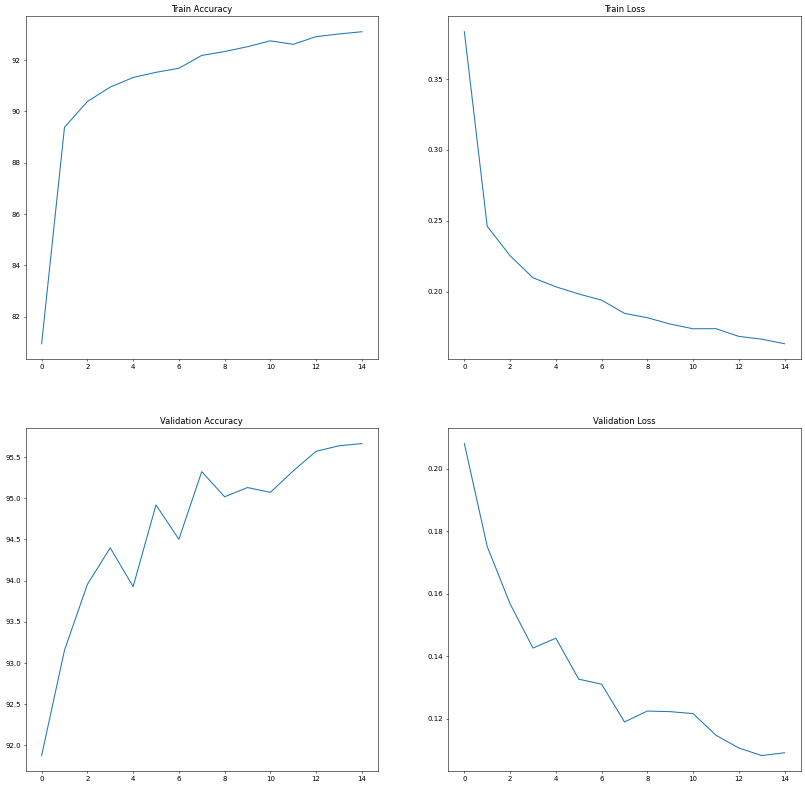

In [ ]:
plt.figure(figsize=(20, 20), dpi=50)

plt.subplot(2, 2, 1)
plt.title('Train Accuracy')
plt.plot(logs[1])

plt.subplot(2, 2, 2)
plt.title('Train Loss')
plt.plot(logs[0])

plt.subplot(2, 2, 3)
plt.title('Validation Accuracy')
plt.plot(logs[6])

plt.subplot(2, 2, 4)
plt.title('Validation Loss')
plt.plot(logs[5])

**display validate and train f scores graphs**

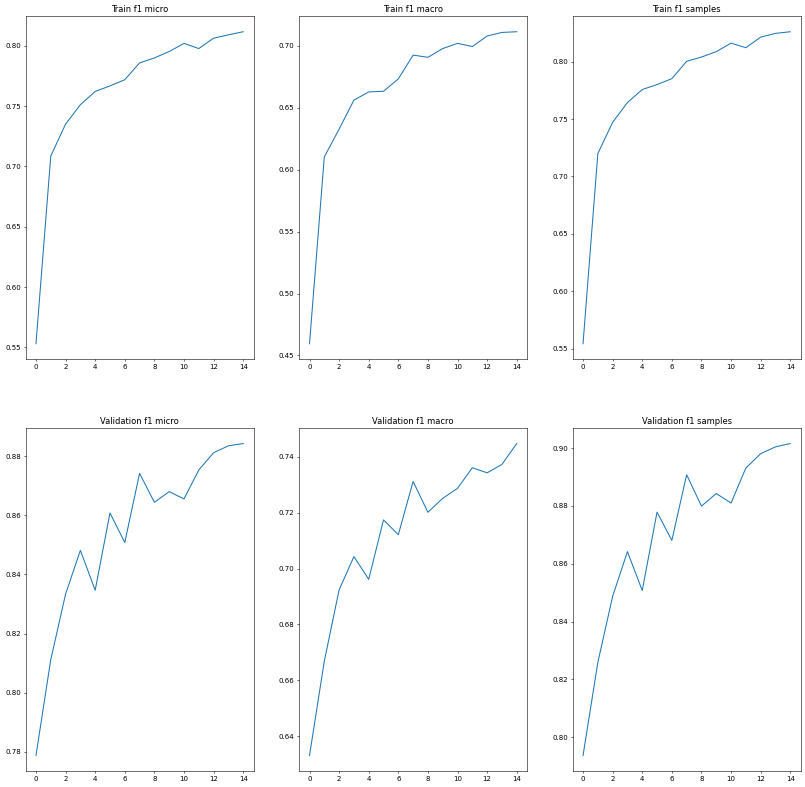

In [ ]:
plt.figure(figsize=(20, 20), dpi=50)

plt.subplot(2, 3, 1)
plt.title('Train f1 micro')
plt.plot(logs[2])

plt.subplot(2, 3, 2)
plt.title('Train f1 macro')
plt.plot(logs[3])

plt.subplot(2, 3, 3)
plt.title('Train f1 samples')
plt.plot(logs[4])

plt.subplot(2, 3, 4)
plt.title('Validation f1 micro')
plt.plot(logs[7])

plt.subplot(2, 3, 5)
plt.title('Validation f1 macro')
plt.plot(logs[8])

plt.subplot(2, 3, 6)
plt.title('Validation f1 samples')
plt.plot(logs[9])

**load all trained models for ensemble**

In [ ]:
model_resnet50_trained1 = torch.load('../input/model-resnet50-trained/model_resnet50_2')
model_resnet50_trained2 = torch.load('../input/model-resnet50-trained2/model_resnet50_trained2')

**create models ensemble**

In [ ]:
ensemble = MyEnsemble([model_resnet50_trained1, model_resnet50_trained2,model_resNet34])
ensemble = ensemble.cuda()

In [ ]:
y_true, y_pred_proba = predict(ensemble, valid_loader)

100%|██████████| 233/233 [00:21<00:00, 10.92it/s]

average output values for true label[0.578080790624524, 0.775409517446854, 0.9125128694426488, 0.8981067589392849, 0.8269304417703859, 0.9562947839095786]
average output values for false label[0.04432492267605363, 0.05867902923183706, 0.008289943746036353, 0.01691505545876182, 0.07057671830229083, 0.03571232206852138]


**calculate model ensemble accuracy**

In [ ]:
acc(y_true, y_pred_proba)

0.8514531754574811

**plot confusion matrix**

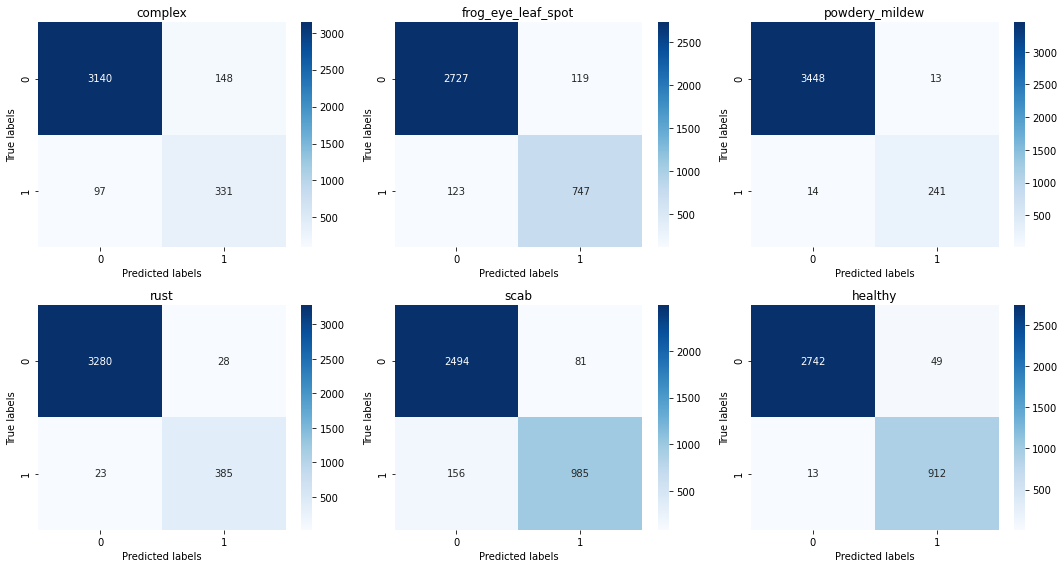

In [ ]:
plot_confusion_matrix(y_true, y_pred_proba)

**submission**

In [ ]:
def save_submission(model):
    """
    """
    image_sub = pd.read_csv(CFG.SAMPLE_SUBMISSION_FILE)
    image_ids = pd.read_csv(CFG.SAMPLE_SUBMISSION_FILE, index_col = 'image')
    
    original_labels = image_ids['labels'].values.copy()
    image_ids['labels'] = [x.split(' ') for x in image_ids['labels']]
    labels = MultiLabelBinarizer(classes=CFG.classes).fit_transform(image_ids['labels'].values)
    image_ids = pd.DataFrame(columns=CFG.classes, data=labels, index=image_ids.index)
    
    dataset = PlantDataset(
        image_ids,
        get_transform('valid'),
        kind = 'test'
    )
    

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for idx, (X, _) in enumerate(loader):
        X = X.to(CFG.DEVICE)    
        y_pred = to_numpy(model(X)).flatten()
        
#         y_pred = Sigmoid(y_pred)
#         y_pred = softmax(y_pred)
        
        pred_max = np.argmax(y_pred)
        
        y_pred = ((y_pred) > CFG.treshold_test).astype(int)
        
        pred_sum = np.sum(y_pred)
        
        if pred_sum == 0:
            y_pred[pred_max] = 1
        
        if y_pred[5] == 1 and pred_sum>1:
            if pred_max == 5:
                y_pred = np.array([0,0,0,0,0,1])
            else:
                y_pred[5] = 0        
        
        pred_labels = ' '.join([CFG.classes[idx] for idx, i in enumerate(y_pred) if i==1]).strip()
        image_sub.iloc[idx]['labels'] = pred_labels
    
    # save data frame as csv
    image_sub.set_index('image', inplace=True)
    image_sub.to_csv(CFG.SUBMISSION_FILE)
    
    return image_sub

In [ ]:
save_submission(ensemble)

labels
image                                                
85f8cb619c66b863.jpg                          complex
ad8770db05586b59.jpg  complex frog_eye_leaf_spot scab
c7b03e718489f3ca.jpg               frog_eye_leaf_spot